In [1]:
import os
import cv2
import xml.dom.minidom
import xml.etree.ElementTree as ET
from xml.dom.minidom import Document  
import math
import numpy as np
import concurrent.futures
from IPython import display
from PIL import Image

In [7]:
def rotate_image(src, angle, scale=1):

    w = src.shape[1]
    h = src.shape[0]
    # 角度变弧度
    rangle = np.deg2rad(angle)  # angle in radians
    # now calculate new image width and height
    nw = (abs(np.sin(rangle) * h) + abs(np.cos(rangle) * w)) * scale
    nh = (abs(np.cos(rangle) * h) + abs(np.sin(rangle) * w)) * scale
    # ask OpenCV for the rotation matrix
    rot_mat = cv2.getRotationMatrix2D((nw * 0.5, nh * 0.5), angle, scale)
    # calculate the move from the old center to the new center combined
    # with the rotation
    rot_move = np.dot(rot_mat, np.array([(nw - w) * 0.5, (nh - h) * 0.5, 0]))
    # the move only affects the translation, so update the translation
    # part of the transform
    rot_mat[0, 2] += rot_move[0]
    rot_mat[1, 2] += rot_move[1]
    dst = cv2.warpAffine(
        src,
        rot_mat, (int(math.ceil(nw)), int(math.ceil(nh))),
        flags=cv2.INTER_LANCZOS4)
    # 仿射变换
    return dst


# 对应修改xml文件
def rotate_xml(src, xmin, ymin, xmax, ymax, angle, scale=1.):
    w = src.shape[1]
    h = src.shape[0]
    rangle = np.deg2rad(angle)  # angle in radians
    # now calculate new image width and height
    nw = (abs(np.sin(rangle) * h) + abs(np.cos(rangle) * w)) * scale
    nh = (abs(np.cos(rangle) * h) + abs(np.sin(rangle) * w)) * scale

    rot_mat = cv2.getRotationMatrix2D((nw * 0.5, nh * 0.5), angle, scale)
    # calculate the move from the old center to the new center combined
    # with the rotation
    rot_move = np.dot(rot_mat, np.array([(nw - w) * 0.5, (nh - h) * 0.5, 0]))
    # the move only affects the translation, so update the translation
    # part of the transform
    rot_mat[0, 2] += rot_move[0]
    rot_mat[1, 2] += rot_move[1]  

    ## method 1 (more bigger)
    point1 = np.dot(rot_mat, np.array([xmin, ymin, 1]))
    point2 = np.dot(rot_mat, np.array([xmax, ymin, 1]))
    point3 = np.dot(rot_mat, np.array([xmax, ymax, 1]))
    point4 = np.dot(rot_mat, np.array([xmin, ymax, 1]))

    ## method 2
    point1 = np.dot(rot_mat, np.array([(xmin + xmax) / 2, ymin, 1]))
    point2 = np.dot(rot_mat, np.array([xmax, (ymin + ymax) / 2, 1]))
    point3 = np.dot(rot_mat, np.array([(xmin + xmax) / 2, ymax, 1]))
    point4 = np.dot(rot_mat, np.array([xmin, (ymin + ymax) / 2, 1]))
    
    concat = np.vstack((point1, point2, point3, point4))
    concat = concat.astype(np.int32)
    rx, ry, rw, rh = cv2.boundingRect(concat)
    
    ## adjust the bbox
    #     rx = max(rx-40,0)
    #     ry = max(ry-40,0)
    #     rw = rw+70
    #     rh = rh+70
    
    return rx, ry, rw, rh

B102_IMG_6100.JPG
B102_IMG_6100.JPG has been rotated for 30°


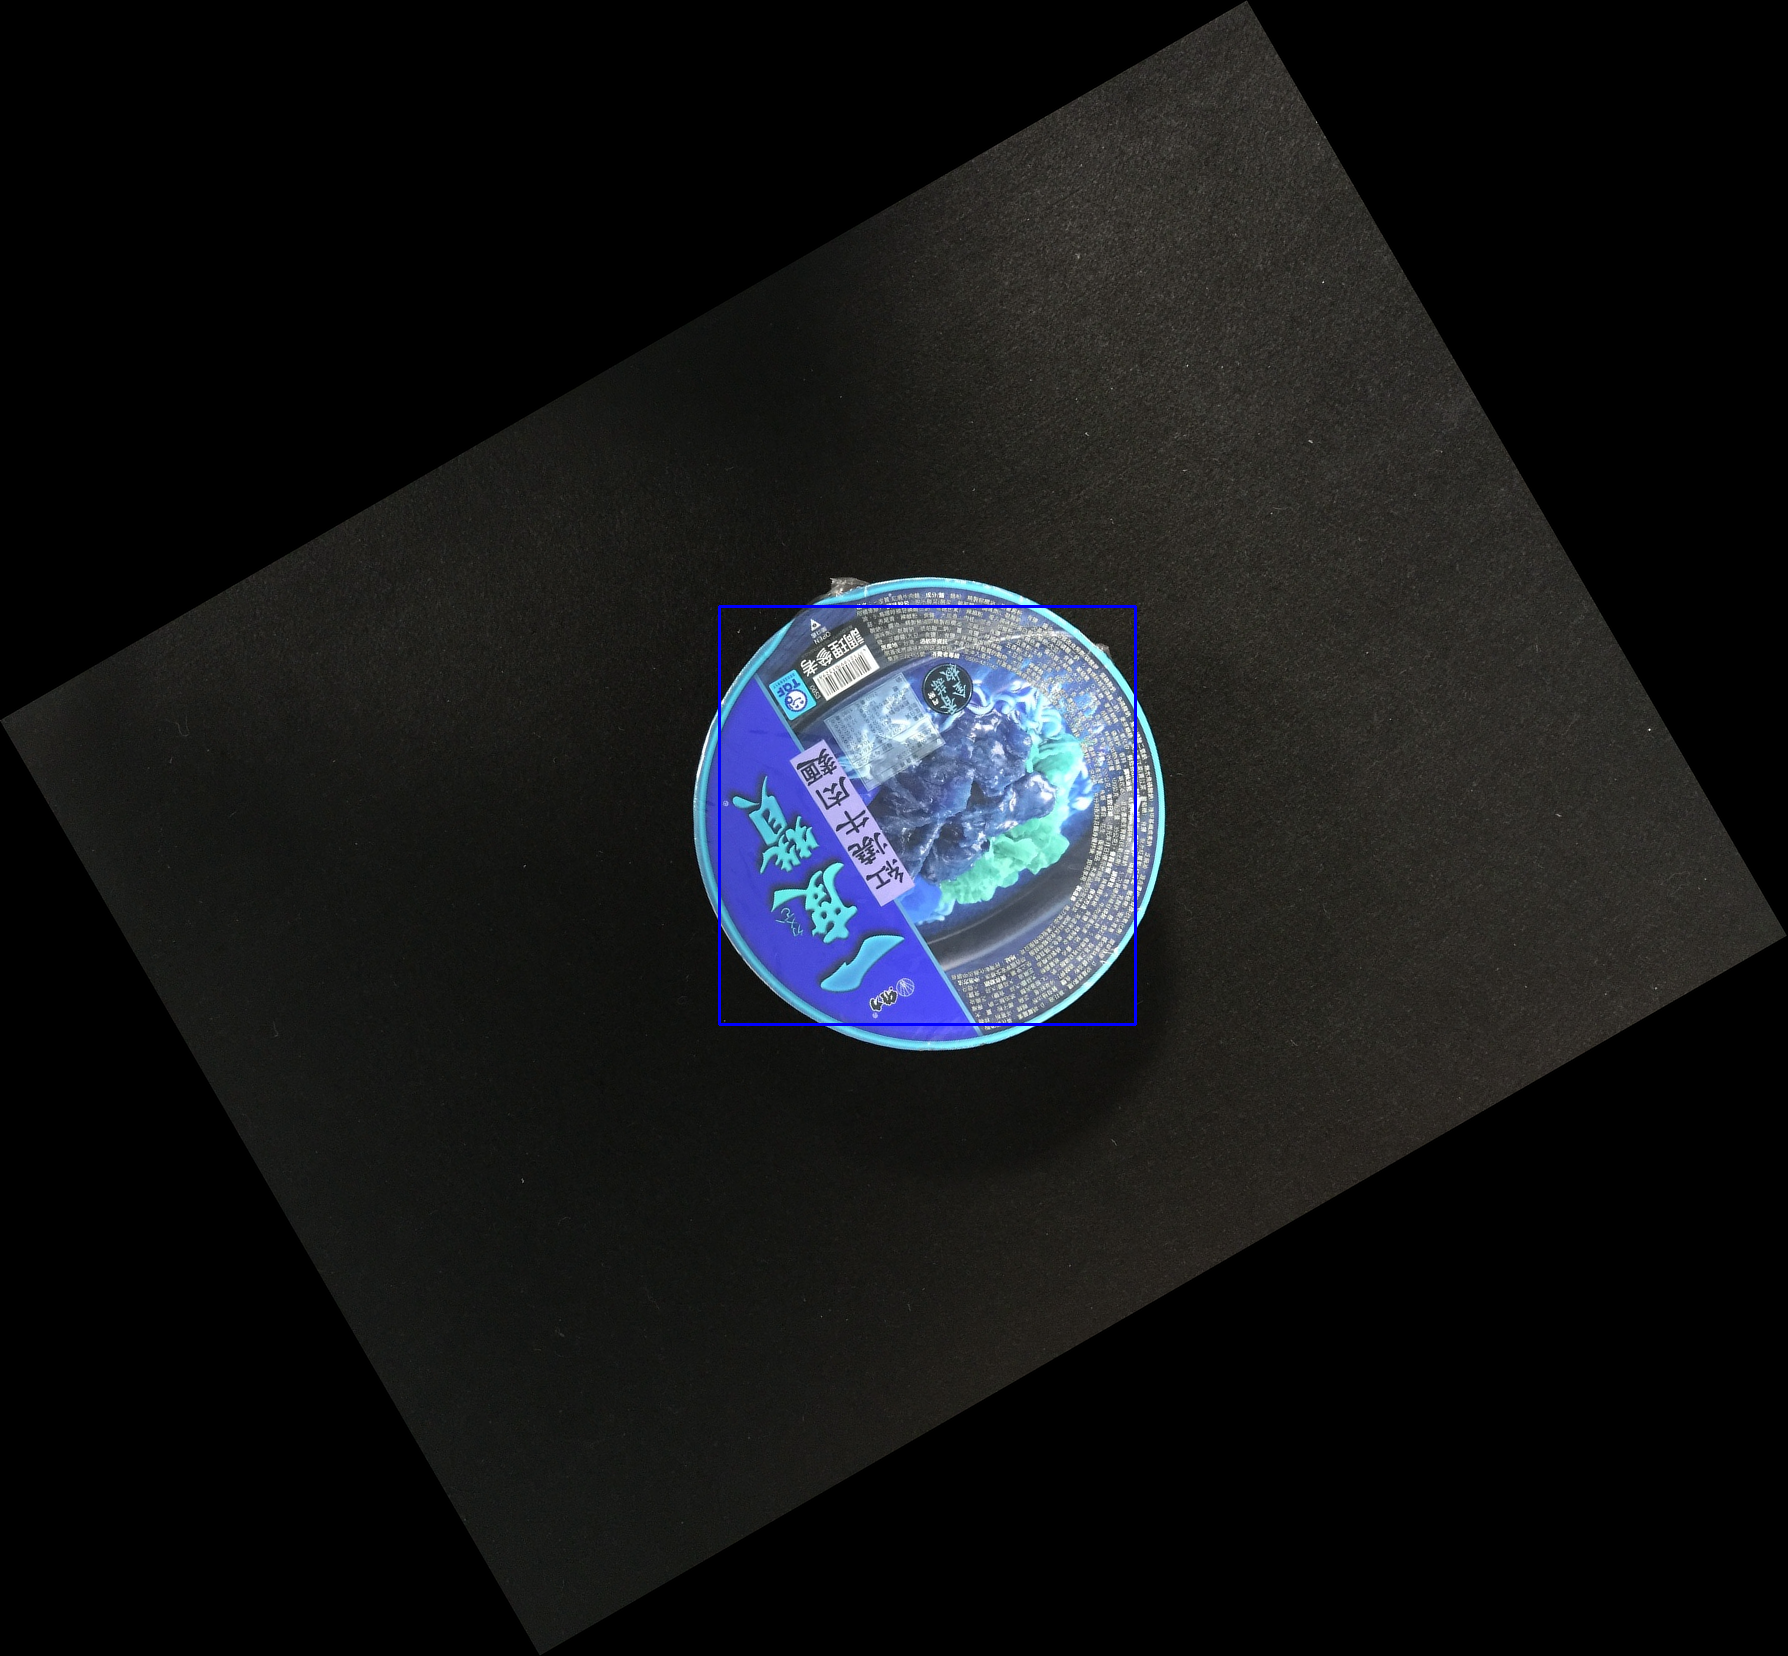

B102_IMG_6100.xml has been rotated for 30°
B102_IMG_6100.JPG
B102_IMG_6100.JPG has been rotated for 330°


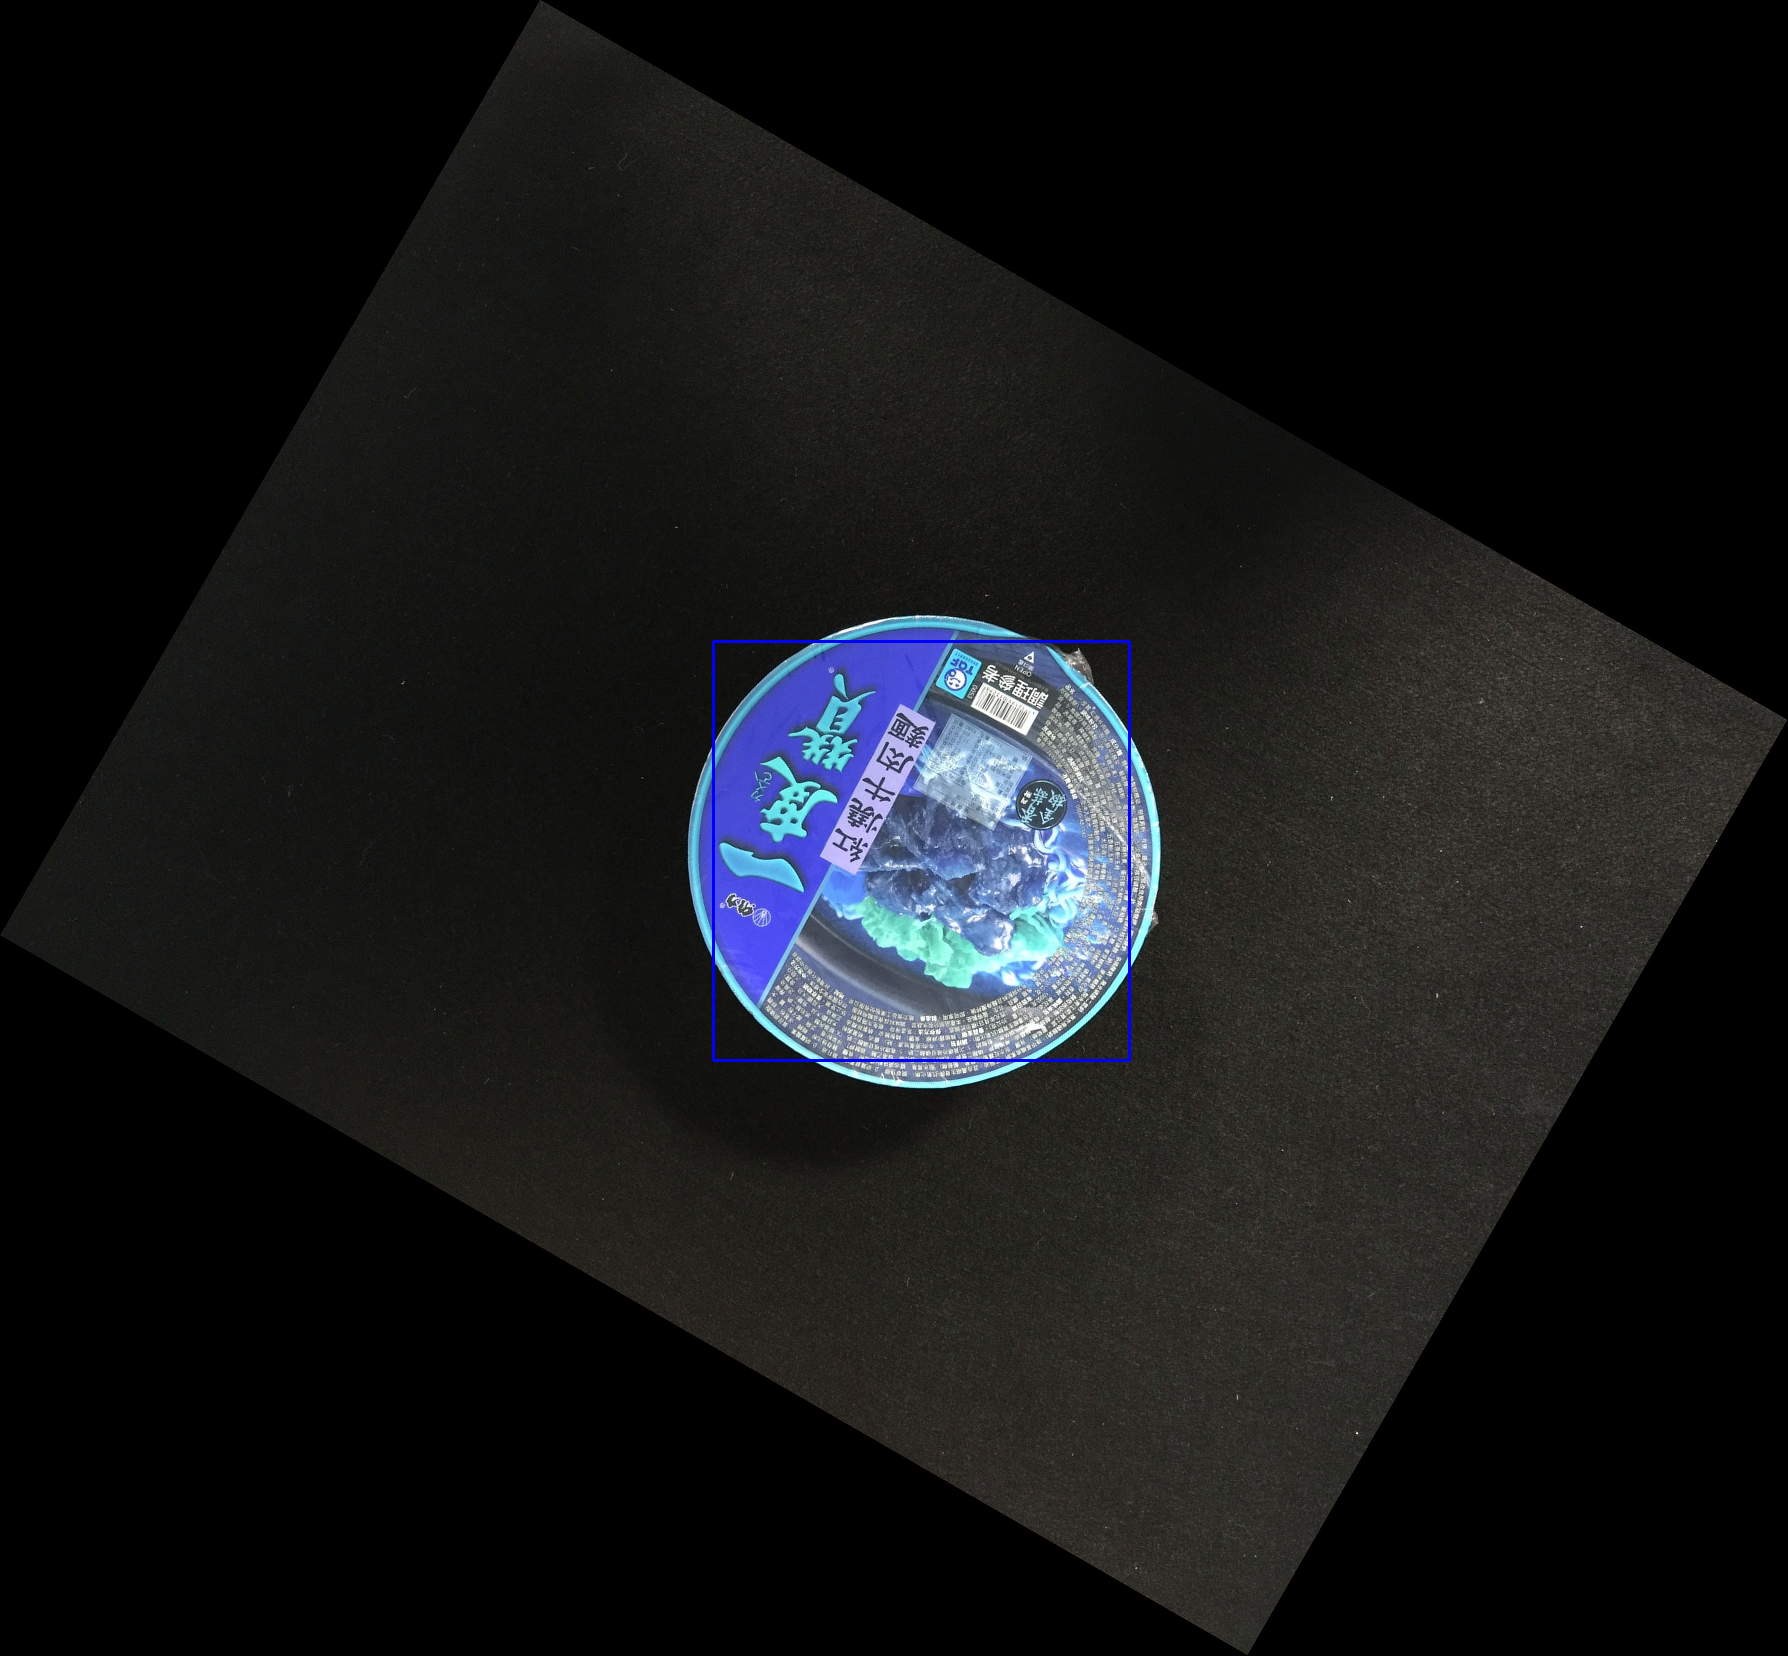

B102_IMG_6100.xml has been rotated for 330°


In [8]:
# rotate 30,60,90,120,150,210,240,270,300,330 degrees

xmlpath = '/home/challenge/Matlab/keras-yolo3/test/single_xml/'  # source xml
imgpath = '/home/challenge/Matlab/keras-yolo3/test/single_img/'  # source img
rotated_xmlpath = '/home/challenge/Matlab/keras-yolo3/test/rotated_xml/' # target xml
rotated_imgpath = '/home/challenge/Matlab/keras-yolo3/test/rotated_img/' # target img

for angle in (30, 330):
    for i in os.listdir(imgpath):
        print(i)
        a, b = os.path.splitext(i)  #分离出文件名a
        img = cv2.imread(imgpath + a + '.JPG')
        rotated_img = rotate_image(img, angle)
        cv2.imwrite(rotated_imgpath + a + '_' + str(angle) + 'd.jpg',
                    rotated_img)
        print(str(i) + ' has been rotated for ' + str(angle) + '°')
        tree = ET.parse(xmlpath + a + '.xml')
        root = tree.getroot()
        for box in root.iter('bndbox'):
            xmin = float(box.find('xmin').text)
            ymin = float(box.find('ymin').text)
            xmax = float(box.find('xmax').text)
            ymax = float(box.find('ymax').text)
            x, y, w, h = rotate_xml(img, xmin, ymin, xmax, ymax, angle)
            
            ## check img
            cv2.rectangle(rotated_img, (x, y), (x + w, y + h), [0, 0, 255], 2)
            display.display(Image.fromarray(rotated_img))
            ##
            
            box.find('xmin').text = str(x)
            box.find('ymin').text = str(y)
            box.find('xmax').text = str(x + w)
            box.find('ymax').text = str(y + h)
        tree.write(rotated_xmlpath + a + '_' + str(angle) + 'd.xml')
        print(str(a) + '.xml has been rotated for ' + str(angle) + '°')